# Compare EscapeMap mutation predictions with Baum et al. 

In [1]:
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.pyplot as plt



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import random
import os
sys.path.append("..")
from global_variables import *
from escape_map import EscapeMap, load_escape_map_from_csv,gen_artif_data, score_seq_batch
from utils import get_Kd

pgm_dir=('../')
sys.path.append(pgm_dir+'./utilities')

# Now safe to import
import utilities, Proteins_utils, sequence_logo, plots_utils
import rbm, RBM_utils  # rbm.py must be alongside this file

E:\ESCAPE_MAP_DRAFT\PGM\source\numba_utilities.py:1124: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 2, 'F', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  dmean_v_dw = np.dot(s1.T, V)
E:\ESCAPE_MAP_DRAFT\PGM\source\numba_utilities.py:961: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 1, 'A', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  mean_V = np.dot(weights, V) / sum_weights
C:\Users\maria\AppData\Roaming\Python\Python312\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


Loaded 29 KD vectors
Loaded 2 KD vectors
Loaded 671 KD vectors
Loaded 438 KD vectors


In [3]:
train_date = pd.Timestamp("2020-04-01")  



em_path = "../params_by_period_0.03_m1_m8_m8/param_period_"+train_date.strftime("%Y-%m-%d")+".csv"


In [4]:
ab_names=list(KD_VECTORS.keys())
ab_index_1=ab_names.index('REGN10933')
ab_index_2=ab_names.index('REGN10987')

print(ab_index_1,ab_index_2)

14 15


# Best mutations in case of unique antibody

In [5]:
df_bloom=pd.read_csv('../exp_data/starr_science/bloom_deep_scan_ACE2_with_sequence.csv')
df_bloom=df_bloom[df_bloom['site_SARS2']>=349] 
df_bloom=df_bloom[df_bloom['site_SARS2']<=526]
#reset index
df_bloom=df_bloom.reset_index(drop=True)
#sequence column to fasta file
with open('../exp_data/starr_science/bloom_deep_scan_ACE2_with_sequence.fasta', 'w') as f:
    for index, row in df_bloom.iterrows():
        #if * in sequence, remove sequence
        if '*' in row['sequence']:
            continue
        f.write('>' + str(index) + '\n')
        f.write(row['sequence'] + '\n')
df_bloom

,site_RBD,site_SARS2,wildtype,mutant,mutation,mutation_RBD,bind_lib1,bind_lib2,bind_avg,expr_lib1,expr_lib2,expr_avg,sequence
0,19,349,S,A,S349A,S19A,-0.35,-0.32,-0.34,-1.37,-0.89,-1.13,NITNLCPFGEVFNATRFAAVYAWNRKRISNCVADYSVLYNSASFST...
1,19,349,S,C,S349C,S19C,0.00,-0.24,-0.12,-3.09,-0.97,-2.03,NITNLCPFGEVFNATRFACVYAWNRKRISNCVADYSVLYNSASFST...
2,19,349,S,D,S349D,S19D,-0.48,-0.52,-0.50,-1.06,-1.21,-1.14,NITNLCPFGEVFNATRFADVYAWNRKRISNCVADYSVLYNSASFST...
3,19,349,S,E,S349E,S19E,-1.08,-1.23,-1.15,-2.22,-2.04,-2.13,NITNLCPFGEVFNATRFAEVYAWNRKRISNCVADYSVLYNSASFST...
4,19,349,S,F,S349F,S19F,-1.96,-2.11,-2.03,-2.67,-2.33,-2.50,NITNLCPFGEVFNATRFAFVYAWNRKRISNCVADYSVLYNSASFST...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3322,196,526,G,R,G526R,G196R,-0.08,-0.08,-0.08,-0.19,-0.40,-0.30,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
3323,196,526,G,S,G526S,G196S,0.00,-0.05,-0.02,-0.14,-0.13,-0.14,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
3324,196,526,G,T,G526T,G196T,0.05,-0.04,0.01,-0.20,-0.11,-0.15,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
3325,196,526,G,V,G526V,G196V,-0.07,-0.02,-0.04,-0.12,-0.13,-0.12,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...


### Make predictions

In [6]:
bloom_sequences=Proteins_utils.load_FASTA('../exp_data/starr_science/bloom_deep_scan_ACE2_with_sequence.fasta')
print('shape of sequences:', np.shape(bloom_sequences))
bloom_sequences = [seq[BEGIN:-END] for seq in bloom_sequences]
bloom_sequences=np.array(bloom_sequences)


bloom_sequences.shape

shape of sequences: (3327, 201)


(3327, 178)

In [7]:
WT_embe=Proteins_utils.load_FASTA('../seq_data/rbd_wt.fasta')
WT_embe = [seq[BEGIN:-END] for seq in WT_embe]
WT_seq=np.array(WT_embe)




In [8]:
import torch

c=-6



In [9]:
import pandas as pd
print('ab_name_1:',ab_names[ab_index_1])
results = []
print('c:', c)
model=load_escape_map_from_csv(em_path)
model.raw_concentrations=model.raw_concentrations*0-12
print('concentration:',model.raw_concentrations)
model.raw_concentrations[ab_index_1] = c


energies = [model(s) for s in bloom_sequences]

df_bloom['E_ACE2_RBM_AB'] = energies
E_wt = model(WT_seq).item()
df_bloom['-deltaE_ACE2_RBM_AB'] = E_wt- df_bloom['E_ACE2_RBM_AB']




concentrations = torch.full((29,), -25)
model=load_escape_map_from_csv(em_path)
model.raw_concentrations=model.raw_concentrations*0-12
model.raw_concentrations[ab_index_1] = c
model.raw_ace2=0

model.raw_beta=-10
energies = [model(torch.tensor(s, dtype=torch.int16)).item() for s in bloom_sequences]
df_bloom['E_AB'] = energies
E_wt = model(WT_seq)
df_bloom['-deltaE_AB'] = E_wt - df_bloom['E_AB']
#keep only one nucleotide away
# df_bloom_trimmed = df_bloom[df_bloom['one_nucleotide_away']]
# df_bloom_avg = df_bloom_trimmed.groupby(['site_SARS2']).mean().reset_index()


df_bloom_avg = df_bloom.groupby('site_SARS2').agg(lambda x: x.mean() if np.issubdtype(x.dtype, np.number) else x.iloc[0]).reset_index()
df_bloom_avg
    


ab_name_1: REGN10933
c: -6
concentration: [-12. -12. -12. -12. -12. -12. -12. -12. -12. -12. -12. -12. -12. -12.
 -12. -12. -12. -12. -12. -12. -12. -12. -12. -12. -12. -12. -12. -12.
 -12.]


,site_SARS2,site_RBD,wildtype,mutant,mutation,mutation_RBD,bind_lib1,bind_lib2,bind_avg,expr_lib1,expr_lib2,expr_avg,sequence,E_ACE2_RBM_AB,-deltaE_ACE2_RBM_AB,E_AB,-deltaE_AB
0,349,19.0,S,A,S349A,S19A,-1.153684,-1.152105,-1.152105,-1.941053,-1.807895,-1.875263,NITNLCPFGEVFNATRFAAVYAWNRKRISNCVADYSVLYNSASFST...,-1339.587036,-10.266184,5.434176,-0.161766
1,350,20.0,V,A,V350A,V20A,-2.873333,-2.721667,-2.798889,-2.285000,-2.210000,-2.247222,NITNLCPFGEVFNATRFASAYAWNRKRISNCVADYSVLYNSASFST...,-1331.320679,-18.532545,5.273134,-0.000724
2,351,21.0,Y,A,Y351A,Y21A,-1.035789,-1.073158,-1.055263,-1.898421,-1.785789,-1.842632,NITNLCPFGEVFNATRFASVAAWNRKRISNCVADYSVLYNSASFST...,-1338.244873,-11.608192,5.455982,-0.183572
3,352,22.0,A,C,A352C,A22C,-0.310000,-0.360526,-0.335263,-0.957368,-0.898421,-0.927368,NITNLCPFGEVFNATRFASVYCWNRKRISNCVADYSVLYNSASFST...,-1339.979492,-9.873709,5.500353,-0.227943
4,353,23.0,W,A,W353A,W23A,-1.598421,-1.606842,-1.603684,-2.225263,-2.206842,-2.214211,NITNLCPFGEVFNATRFASVYAANRKRISNCVADYSVLYNSASFST...,-1335.012451,-14.840898,5.392087,-0.119677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,522,192.0,A,C,A522C,A192C,-0.003158,-0.018947,-0.011053,-0.051579,-0.177895,-0.115263,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,-1340.986572,-8.866558,5.506979,-0.234569
174,523,193.0,T,A,T523A,T193A,-0.018333,-0.036667,-0.028333,-0.258333,-1.110000,-0.686667,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,-1339.313354,-10.539754,5.451775,-0.179365
175,524,194.0,V,A,V524A,V194A,-0.552000,-0.034000,-0.294000,0.026000,-0.636000,-0.306000,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,-1340.571655,-9.281469,5.481496,-0.209087
176,525,195.0,C,A,C525A,C195A,-0.203889,-0.095556,-0.150000,-0.352222,-0.620000,-0.487778,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,-1337.470703,-12.382365,5.485921,-0.213512


In [10]:
observed_sites = [417, 453, 455, 486, 493]
df_bloom_avg['observed_label'] = df_bloom_avg['site_SARS2'].isin(observed_sites).astype(int)




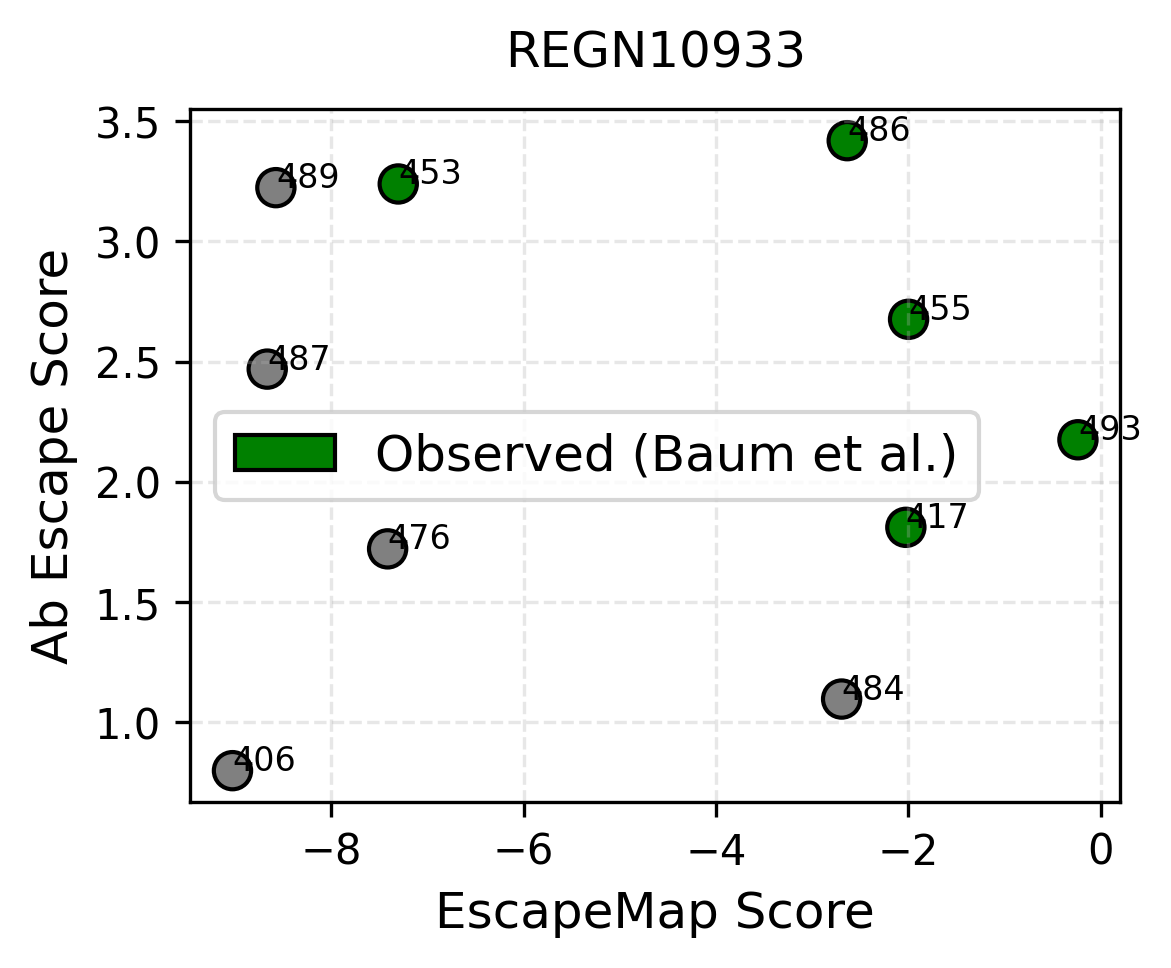

In [11]:
# Sort the dataframe by -deltaE_AB and select top 10 rows
top10_df = df_bloom_avg.sort_values('-deltaE_AB', ascending=False).head(10)
# Define colors based on observed_label
colors = top10_df['observed_label'].map({1: 'green', 0: 'grey'})

# Create scatter plot
plt.figure(figsize=(4, 3), dpi=300)
plt.scatter(top10_df['-deltaE_ACE2_RBM_AB'], top10_df['-deltaE_AB'],
            c=colors, s=80, edgecolors='k')

# # Annotate each point with its site_SARS2 value, slightly offset
for _, row in top10_df.iterrows():
    plt.text(row['-deltaE_ACE2_RBM_AB'] ,  # slight right shift
             row['-deltaE_AB'] ,           # slight upward shift
             str(row['site_SARS2']), fontsize=8, ha='left')



# Label axes and title
plt.xlabel('EscapeMap Score', fontsize=12)
plt.ylabel('Ab Escape Score', fontsize=12)
plt.title('REGN10933', fontsize=12, pad=10)
#add lines x=0 and y=0
# plt.axhline(0, color='gray', linestyle='--', linewidth=1.5)
# plt.axvline(0, color='gray', linestyle='--', linewidth=1.5)
# Legend proxy
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='green', edgecolor='k', label='Observed (Baum et al.)')]
plt.legend(handles=legend_elements, fontsize=12, loc='best', frameon=True)

plt.grid(alpha=0.3, linestyle='--')
plt.show()


In [12]:
import pandas as pd
print('ab_name_2:',ab_names[ab_index_2])
results = []

print('c:', c)
model=load_escape_map_from_csv(em_path)
model.raw_concentrations=model.raw_concentrations*0-12
print('concentration:',model.raw_concentrations)
model.raw_concentrations[ab_index_2] = c


energies = [model(s) for s in bloom_sequences]

df_bloom['E_ACE2_RBM_AB'] = energies
E_wt = model(WT_seq).item()
df_bloom['-deltaE_ACE2_RBM_AB'] = E_wt- df_bloom['E_ACE2_RBM_AB']




concentrations = torch.full((29,), -25)
concentrations[ab_index_2] = c
model=load_escape_map_from_csv(em_path)
model.raw_concentrations=model.raw_concentrations*0-12
model.raw_ace2=0
model.raw_beta=-10
#print concentration
print('concentration:',model.raw_concentrations)
model.raw_concentrations[ab_index_2] = c
energies = [model(s) for s in bloom_sequences]
df_bloom['E_AB'] = energies
E_wt = model(WT_seq)
df_bloom['-deltaE_AB'] = E_wt - df_bloom['E_AB']
#keep only one nucleotide away
# df_bloom_trimmed = df_bloom[df_bloom['one_nucleotide_away']]
# df_bloom_avg = df_bloom_trimmed.groupby(['site_SARS2']).mean().reset_index()


df_bloom_avg = df_bloom.groupby('site_SARS2').agg(lambda x: x.mean() if np.issubdtype(x.dtype, np.number) else x.iloc[0]).reset_index()
df_bloom_avg
    

    


ab_name_2: REGN10987
c: -6
concentration: [-12. -12. -12. -12. -12. -12. -12. -12. -12. -12. -12. -12. -12. -12.
 -12. -12. -12. -12. -12. -12. -12. -12. -12. -12. -12. -12. -12. -12.
 -12.]
concentration: [-12. -12. -12. -12. -12. -12. -12. -12. -12. -12. -12. -12. -12. -12.
 -12. -12. -12. -12. -12. -12. -12. -12. -12. -12. -12. -12. -12. -12.
 -12.]


,site_SARS2,site_RBD,wildtype,mutant,mutation,mutation_RBD,bind_lib1,bind_lib2,bind_avg,expr_lib1,expr_lib2,expr_avg,sequence,E_ACE2_RBM_AB,-deltaE_ACE2_RBM_AB,E_AB,-deltaE_AB
0,349,19.0,S,A,S349A,S19A,-1.153684,-1.152105,-1.152105,-1.941053,-1.807895,-1.875263,NITNLCPFGEVFNATRFAAVYAWNRKRISNCVADYSVLYNSASFST...,-1339.721436,-10.267090,5.299695,-0.162694
1,350,20.0,V,A,V350A,V20A,-2.873333,-2.721667,-2.798889,-2.285000,-2.210000,-2.247222,NITNLCPFGEVFNATRFASAYAWNRKRISNCVADYSVLYNSASFST...,-1331.456055,-18.532532,5.137725,-0.000724
2,351,21.0,Y,A,Y351A,Y21A,-1.035789,-1.073158,-1.055263,-1.898421,-1.785789,-1.842632,NITNLCPFGEVFNATRFASVAAWNRKRISNCVADYSVLYNSASFST...,-1338.379395,-11.609215,5.321626,-0.184626
3,352,22.0,A,C,A352C,A22C,-0.310000,-0.360526,-0.335263,-0.957368,-0.898421,-0.927368,NITNLCPFGEVFNATRFASVYCWNRKRISNCVADYSVLYNSASFST...,-1340.113647,-9.874981,5.366258,-0.229256
4,353,23.0,W,A,W353A,W23A,-1.598421,-1.606842,-1.603684,-2.225263,-2.206842,-2.214211,NITNLCPFGEVFNATRFASVYAANRKRISNCVADYSVLYNSASFST...,-1335.147095,-14.841546,5.257361,-0.120360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,522,192.0,A,C,A522C,A192C,-0.003158,-0.018947,-0.011053,-0.051579,-0.177895,-0.115263,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,-1341.120728,-8.867882,5.372921,-0.235921
174,523,193.0,T,A,T523A,T193A,-0.018333,-0.036667,-0.028333,-0.258333,-1.110000,-0.686667,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,-1339.447876,-10.540751,5.317397,-0.180396
175,524,194.0,V,A,V524A,V194A,-0.552000,-0.034000,-0.294000,0.026000,-0.636000,-0.306000,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,-1340.705933,-9.282593,5.347291,-0.210290
176,525,195.0,C,A,C525A,C195A,-0.203889,-0.095556,-0.150000,-0.352222,-0.620000,-0.487778,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,-1337.601074,-12.387539,5.355725,-0.218725


In [13]:
observed_sites=[444,445]


df_bloom_avg['observed_label'] = df_bloom_avg['site_SARS2'].isin(observed_sites).astype(int)




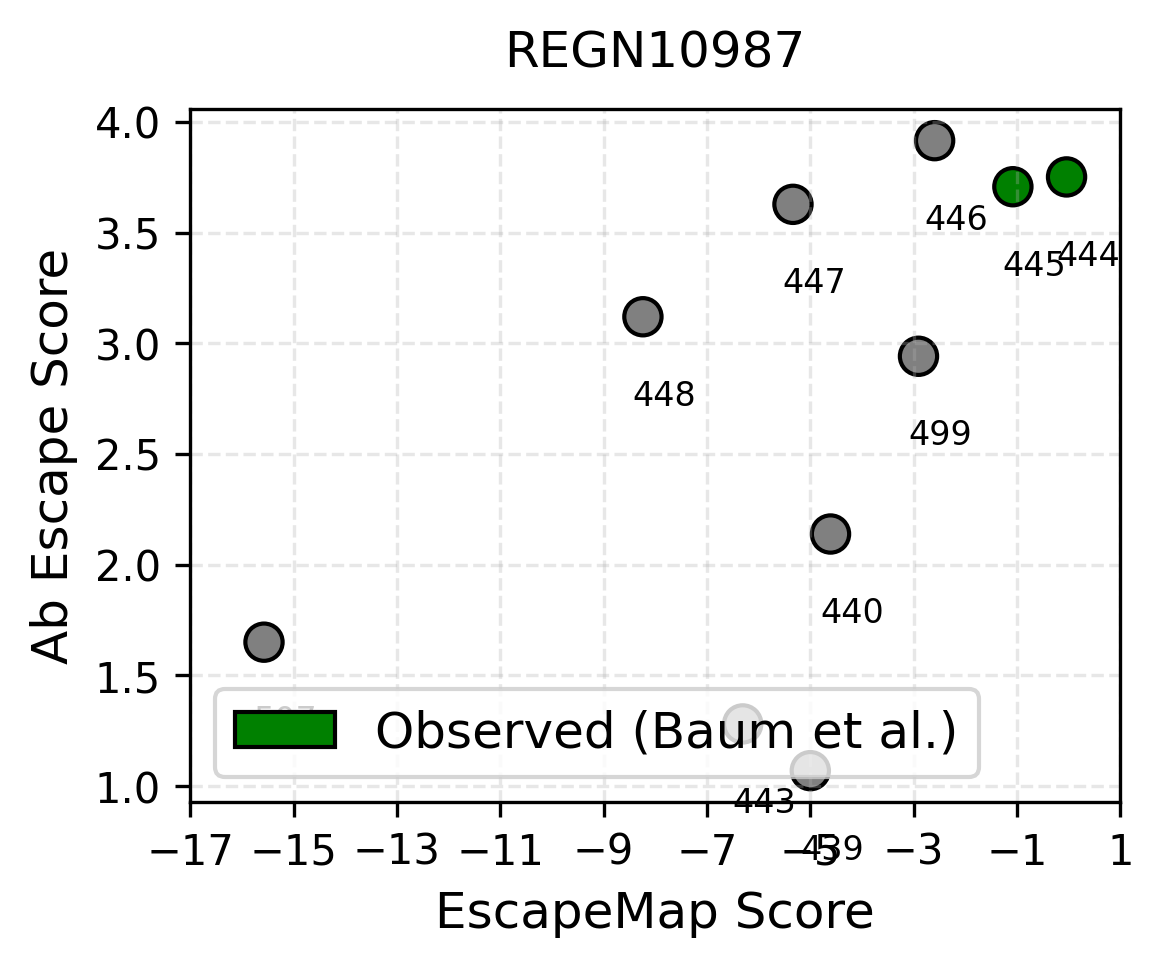

In [14]:
# Sort the dataframe by -deltaE_AB and select top 10 rows
top10_df = df_bloom_avg.sort_values('-deltaE_AB', ascending=False).head(10)

# Define colors based on observed_label
colors = top10_df['observed_label'].map({1: 'green', 0: 'grey'})

# Create scatter plot
plt.figure(figsize=(4, 3), dpi=300)
plt.scatter(top10_df['-deltaE_ACE2_RBM_AB'], top10_df['-deltaE_AB'],
            c=colors, s=80, edgecolors='k')

# Annotate each point with its site_SARS2 value, slightly offset
for _, row in top10_df.iterrows():
    plt.text(row['-deltaE_ACE2_RBM_AB'] - 0.2,  # slight right shift
             row['-deltaE_AB'] - 0.4,           # slight upward shift
             str(row['site_SARS2']), fontsize=8, ha='left')



# Label axes and title
plt.xlabel('EscapeMap Score', fontsize=12)
plt.ylabel('Ab Escape Score', fontsize=12)
plt.title('REGN10987', fontsize=12, pad=10)
#add lines x=0 and y=0
# plt.axhline(0, color='gray', linestyle='--', linewidth=1.5)
# plt.axvline(0, color='gray', linestyle='--', linewidth=1.5)
# Legend proxy
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='green', edgecolor='k', label='Observed (Baum et al.)'),
              ]
plt.legend(handles=legend_elements, fontsize=12, loc='lower left')
# Get min and max values of x-axis
x_min, x_max = plt.xlim()

# Set x-ticks as integers within the range
plt.xticks(np.arange(np.floor(x_min), np.ceil(x_max) + 1, 2))
plt.grid(alpha=0.3, linestyle='--')
plt.show()
